In [116]:
import glob

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import model_selection
import tensorflow as tf
from tensorflow import keras

In [2]:
%matplotlib inline

# Introduction to binary classification using Keras and Tensorflow

## 1. Create a DataFrame of the images filenames and class labels

We will use this `DataFrame` to create the training, validation, and testing image generators.

In [3]:
filepaths = glob.glob("../data/raw/dogs-vs-cats-redux-kernel-edition/train/*.jpg")
data = {"filename": [], "class": []}
for filepath in filepaths:
    filename = filepath.split('/')[-1]
    data["filename"].append(filename)
    if filename.startswith("dog"):
        data["class"].append(1)
    else:
        data["class"].append(0)

df = pd.DataFrame.from_dict(data)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
filename    25000 non-null object
class       25000 non-null int64
dtypes: int64(1), object(1)
memory usage: 390.7+ KB


In [5]:
df.head()

,filename,class
0,cat.0.jpg,0
1,cat.1.jpg,0
2,cat.10.jpg,0
3,cat.100.jpg,0
4,cat.1000.jpg,0


In [6]:
df.tail()

,filename,class
24995,dog.9995.jpg,1
24996,dog.9996.jpg,1
24997,dog.9997.jpg,1
24998,dog.9998.jpg,1
24999,dog.9999.jpg,1


## 2. Split the training data into training and validation sets

Dividing the full training data set into training and validation data sets will help us make sure that we are not overfitting out models. Once we have identified a good model architecture we will re-train using the full data set prior to making predictions.

In [7]:
_prng = np.random.RandomState(42)
training_df, validation_df = model_selection.train_test_split(df,
                                                              test_size=0.1,
                                                              random_state=_prng,
                                                              shuffle=True)

# flow_from_dataframe expects a particular index!
training_df.reset_index(drop=True, inplace=True)
validation_df.reset_index(drop=True, inplace=True)

In [8]:
training_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22500 entries, 0 to 22499
Data columns (total 2 columns):
filename    22500 non-null object
class       22500 non-null int64
dtypes: int64(1), object(1)
memory usage: 351.6+ KB


In [9]:
training_df.head()

,filename,class
0,cat.2784.jpg,0
1,cat.9150.jpg,0
2,dog.2708.jpg,1
3,cat.6791.jpg,0
4,cat.8452.jpg,0


In [10]:
NUMBER_TRAINING_SAMPLES, _ = training_df.shape

In [11]:
validation_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 2 columns):
filename    2500 non-null object
class       2500 non-null int64
dtypes: int64(1), object(1)
memory usage: 39.1+ KB


In [12]:
validation_df.head()

,filename,class
0,cat.493.jpg,0
1,dog.9112.jpg,1
2,cat.745.jpg,0
3,dog.11022.jpg,1
4,dog.11363.jpg,1


In [13]:
NUMBER_VALIDATION_SAMPLES, _ = validation_df.shape

## 3. Training and Validation Preprocessing

To start we need to rescale the images so that the images are represented as arrays of floating point numbers between 0 and 1 instead of arrays of integers between 0 and 255. We also need to resize the images so that all images have the same width and height as measured by pixels.  We will discuss more advanced preprocessing in a later section on data augmentation.

In [102]:
TARGET_SIZE = (160, 160)
INPUT_SHAPE = TARGET_SIZE + (3,)
BATCH_SIZE = 20

_generator_kwargs = {"rescale": 1 / 255}

_training_flow_kwargs = {"dataframe": training_df,
                         "directory": "../data/raw/dogs-vs-cats-redux-kernel-edition/train/",
                         "target_size": TARGET_SIZE,
                         "class_mode": "binary",
                         "batch_size": BATCH_SIZE,
                         "seed": 42}

training_data_flow = (keras.preprocessing
                           .image
                           .ImageDataGenerator(**_generator_kwargs)
                           .flow_from_dataframe(**_training_flow_kwargs))
                     
_validation_flow_kwargs = {"dataframe": validation_df,
                           "directory": "../data/raw/dogs-vs-cats-redux-kernel-edition/train/",
                           "target_size": TARGET_SIZE,
                           "class_mode": "binary",
                           "batch_size": BATCH_SIZE,
                           "seed": 24}

validation_data_flow = (keras.preprocessing
                             .image
                             .ImageDataGenerator(**_generator_kwargs)
                             .flow_from_dataframe(**_validation_flow_kwargs))

Found 22500 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


## 4. Define a benchmark CNN model

In this section we roll our own CNN model to provide a benchmark submission.

In [55]:
model_fn = keras.models.Sequential([
    keras.layers.Conv2D(filters=32, kernel_size=(3,3), input_shape=INPUT_SHAPE),
    keras.layers.BatchNormalization(),
    keras.layers.ReLU(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Conv2D(filters=64, kernel_size=(3,3)),
    keras.layers.BatchNormalization(),
    keras.layers.ReLU(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Conv2D(filters=128, kernel_size=(3,3)),
    keras.layers.BatchNormalization(),
    keras.layers.ReLU(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(512),
    keras.layers.BatchNormalization(),
    keras.layers.ReLU(),
    keras.layers.Dense(1, activation="sigmoid")
])

optimzer = keras.optimizers.RMSprop(lr=1e-3)

loss_fn = keras.losses.BinaryCrossentropy()

_metrics = [
    keras.metrics.BinaryAccuracy(),
    keras.metrics.Recall()
]

model_fn.compile(optimzer, loss_fn, metrics=_metrics)

In [16]:
model_fn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 16)      448       
_________________________________________________________________
batch_normalization_v1 (Batc (None, 126, 126, 16)      64        
_________________________________________________________________
re_lu (ReLU)                 (None, 126, 126, 16)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 32)        4640      
_________________________________________________________________
batch_normalization_v1_1 (Ba (None, 61, 61, 32)        128       
_________________________________________________________________
re_lu_1 (ReLU)               (None, 61, 61, 32)        0         
__________

### 4.1 Define the training loop

In [17]:
_callbacks = [
    keras.callbacks.ReduceLROnPlateau(monitor='val_binary_accuracy', patience=2, verbose=1, factor=0.5, min_lr=0.00001),
    keras.callbacks.EarlyStopping(patience=10)
]

training_metrics = model_fn.fit_generator(training_data_flow,
                                          epochs=5,
                                          steps_per_epoch=NUMBER_TRAINING_SAMPLES // BATCH_SIZE,
                                          callbacks=_callbacks,
                                          validation_data=validation_data_flow,
                                          validation_steps=NUMBER_VALIDATION_SAMPLES // BATCH_SIZE,
                                          verbose=1)

Instructions for updating:
Use tf.cast instead.
Epoch 1/5
1500/1500 [==============================] - 377s 252ms/step - loss: 0.5662 - binary_accuracy: 0.7164 - recall: 0.7013 - val_loss: 0.5006 - val_binary_accuracy: 0.7624 - val_recall: 0.6248
Epoch 2/5
1500/1500 [==============================] - 198s 132ms/step - loss: 0.4392 - binary_accuracy: 0.8004 - recall: 0.7917 - val_loss: 0.4168 - val_binary_accuracy: 0.8132 - val_recall: 0.8469
Epoch 3/5
1500/1500 [==============================] - 193s 128ms/step - loss: 0.3792 - binary_accuracy: 0.8315 - recall: 0.8335 - val_loss: 0.5952 - val_binary_accuracy: 0.7524 - val_recall: 0.5682
Epoch 4/5
1500/1500 [==============================] - 183s 122ms/step - loss: 0.3142 - binary_accuracy: 0.8668 - recall: 0.8632 - val_loss: 0.3935 - val_binary_accuracy: 0.8184 - val_recall: 0.7554
Epoch 5/5
1500/1500 [==============================] - 176s 117ms/step - loss: 0.2564 - binary_accuracy: 0.8952 - recall: 0.8900 - val_loss: 0.4147 - val_bi

### 4.2 Exploring training history

In [18]:
history_df = (pd.DataFrame
                .from_dict(training_metrics.history))

In [19]:
history_df.head()

,loss,binary_accuracy,recall,val_loss,val_binary_accuracy,val_recall
0,0.566188,0.716400,0.701275,0.500609,0.7624,0.624792
1,0.439195,0.800356,0.791733,0.416773,0.8132,0.846922
2,0.379212,0.831511,0.833510,0.595225,0.7524,0.568220
3,0.314164,0.866844,0.863162,0.393465,0.8184,0.755408
4,0.256375,0.895200,0.889981,0.414694,0.8268,0.722962


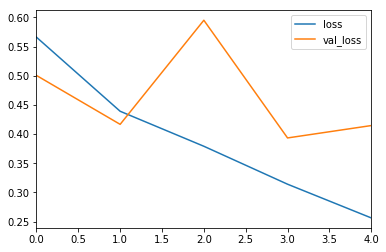

In [20]:
_ = (history_df.loc[:, ["loss", "val_loss"]]
               .plot())

## 5. Image Augmentation to reduce over-fitting

Image augmentation is a simple but powerful tool to help you avoid over-fitting your raw data. Check out the Keras preprocessing module documantion for the details.

Data augmentation is _NOT_ done on disk but rather in memory!

In [103]:
TARGET_SIZE = (160, 160)
INPUT_SHAPE = TARGET_SIZE + (3,)
BATCH_SIZE = 20

model_fn = keras.models.Sequential([
    keras.layers.Conv2D(filters=32, kernel_size=(3,3), input_shape=INPUT_SHAPE),
    keras.layers.BatchNormalization(),
    keras.layers.ReLU(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Conv2D(filters=64, kernel_size=(3,3)),
    keras.layers.BatchNormalization(),
    keras.layers.ReLU(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Conv2D(filters=128, kernel_size=(3,3)),
    keras.layers.BatchNormalization(),
    keras.layers.ReLU(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(512),
    keras.layers.BatchNormalization(),
    keras.layers.ReLU(),
    keras.layers.Dense(1, activation="sigmoid")
])

optimzer = keras.optimizers.RMSprop()

loss_fn = keras.losses.BinaryCrossentropy()

_metrics = [
    keras.metrics.BinaryAccuracy(),
    keras.metrics.Recall()
]

model_fn.compile(optimzer, loss_fn, metrics=_metrics)

In [99]:
_training_generator_kwargs = {"rotation_range": 40,
                              "rescale": 1 / 255,
                              "shear_range": 0.2,
                              "zoom_range": 0.2,
                              "horizontal_flip": True,
                              "width_shift_range": 0.2,
                              "height_shift_range": 0.2,
                              "fill_mode": "nearest"}

_training_flow_kwargs = {"dataframe": training_df,
                         "directory": "../data/raw/dogs-vs-cats-redux-kernel-edition/train/",
                         "target_size": TARGET_SIZE,
                         "class_mode": "binary",
                         "batch_size": BATCH_SIZE,
                         "seed": 42}

training_data_flow = (keras.preprocessing
                           .image
                           .ImageDataGenerator(**_training_generator_kwargs)
                           .flow_from_dataframe(**_training_flow_kwargs))
                    
_validation_generator_kwargs = {"rescale": 1 / 255}

_validation_flow_kwargs = {"dataframe": validation_df,
                           "directory": "../data/raw/dogs-vs-cats-redux-kernel-edition/train/",
                           "target_size": TARGET_SIZE,
                           "class_mode": "binary",
                           "batch_size": BATCH_SIZE,
                           "seed": 24}

validation_data_flow = (keras.preprocessing
                             .image
                             .ImageDataGenerator(**_validation_generator_kwargs)
                             .flow_from_dataframe(**_validation_flow_kwargs))

Found 22500 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


In [100]:
_callbacks = [
    keras.callbacks.ReduceLROnPlateau(monitor='val_binary_accuracy', patience=2, verbose=1, factor=0.5, min_lr=0.00001),
    keras.callbacks.EarlyStopping(patience=10)
]

training_metrics = model_fn.fit_generator(training_data_flow,
                                          epochs=100,
                                          steps_per_epoch=NUMBER_TRAINING_SAMPLES // BATCH_SIZE,
                                          callbacks=_callbacks,
                                          validation_data=validation_data_flow,
                                          validation_steps=NUMBER_VALIDATION_SAMPLES // BATCH_SIZE,
                                          verbose=1)

Epoch 1/100
1125/1125 [==============================] - 259s 230ms/step - loss: 0.6540 - binary_accuracy: 0.6411 - recall_10: 0.6077 - val_loss: 0.5610 - val_binary_accuracy: 0.7164 - val_recall_10: 0.7479
Epoch 2/100
1125/1125 [==============================] - 266s 237ms/step - loss: 0.5567 - binary_accuracy: 0.7136 - recall_10: 0.6875 - val_loss: 0.5370 - val_binary_accuracy: 0.7240 - val_recall_10: 0.5349
Epoch 3/100
1125/1125 [==============================] - 261s 232ms/step - loss: 0.5251 - binary_accuracy: 0.7396 - recall_10: 0.7242 - val_loss: 0.5781 - val_binary_accuracy: 0.7212 - val_recall_10: 0.5308
Epoch 4/100
1125/1125 [==============================] - 257s 229ms/step - loss: 0.4981 - binary_accuracy: 0.7589 - recall_10: 0.7453 - val_loss: 0.4369 - val_binary_accuracy: 0.8020 - val_recall_10: 0.7671
Epoch 5/100
1125/1125 [==============================] - 271s 241ms/step - loss: 0.4806 - binary_accuracy: 0.7709 - recall_10: 0.7598 - val_loss: 0.6627 - val_binary_accura

KeyboardInterrupt: 

In [83]:
history_df = (pd.DataFrame
                .from_dict(training_metrics.history))

Over-fitting problem as been solved by data augmentation!

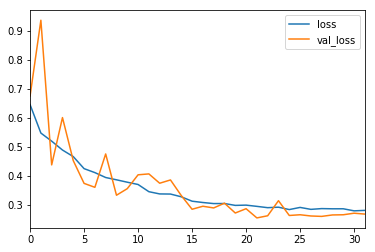

In [84]:
_ = (history_df.loc[:, ["loss", "val_loss"]]
               .plot())

## 6. Improving the model using transfer learning

In [ ]:
keras.applications.MobileNetV2?

In [104]:
feature_extractor = (keras.applications
                          .MobileNetV2(input_shape=INPUT_SHAPE, include_top=False, weights="imagenet"))

feature_extractor.trainable = False

model_fn = keras.models.Sequential([
    feature_extractor,
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(1, activation="sigmoid")
])

optimzer = keras.optimizers.RMSprop(lr=1e-3)

loss_fn = keras.losses.BinaryCrossentropy()

_metrics = [
    keras.metrics.BinaryAccuracy(),
    keras.metrics.Recall()
]

model_fn.compile(optimzer, loss_fn, metrics=_metrics)

9412608/9406464 [==============================] - 13s 1us/step


In [105]:
model_fn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [106]:
_training_generator_kwargs = {"rotation_range": 40,
                              "rescale": 1 / 255,
                              "shear_range": 0.2,
                              "zoom_range": 0.2,
                              "horizontal_flip": True,
                              "width_shift_range": 0.2,
                              "height_shift_range": 0.2,
                              "fill_mode": "nearest"}

_training_flow_kwargs = {"dataframe": training_df,
                         "directory": "../data/raw/dogs-vs-cats-redux-kernel-edition/train/",
                         "target_size": TARGET_SIZE,
                         "class_mode": "binary",
                         "batch_size": BATCH_SIZE,
                         "seed": 42}

training_data_flow = (keras.preprocessing
                           .image
                           .ImageDataGenerator(**_training_generator_kwargs)
                           .flow_from_dataframe(**_training_flow_kwargs))
                    
_validation_generator_kwargs = {"rescale": 1 / 255}

_validation_flow_kwargs = {"dataframe": validation_df,
                           "directory": "../data/raw/dogs-vs-cats-redux-kernel-edition/train/",
                           "target_size": TARGET_SIZE,
                           "class_mode": "binary",
                           "batch_size": BATCH_SIZE,
                           "seed": 24}

validation_data_flow = (keras.preprocessing
                             .image
                             .ImageDataGenerator(**_validation_generator_kwargs)
                             .flow_from_dataframe(**_validation_flow_kwargs))

Found 22500 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


In [107]:
_callbacks = [
    keras.callbacks.ReduceLROnPlateau(monitor='val_binary_accuracy', patience=2, verbose=1, factor=0.5, min_lr=0.00001),
    keras.callbacks.EarlyStopping(patience=10)
]

training_metrics = model_fn.fit_generator(training_data_flow,
                                          epochs=100,
                                          steps_per_epoch=NUMBER_TRAINING_SAMPLES // BATCH_SIZE,
                                          callbacks=_callbacks,
                                          validation_data=validation_data_flow,
                                          validation_steps=NUMBER_VALIDATION_SAMPLES // BATCH_SIZE,
                                          verbose=1)

Epoch 1/100
1125/1125 [==============================] - 262s 233ms/step - loss: 0.2411 - binary_accuracy: 0.8954 - recall_12: 0.8925 - val_loss: 0.1167 - val_binary_accuracy: 0.9548 - val_recall_12: 0.9634
Epoch 2/100
1125/1125 [==============================] - 250s 222ms/step - loss: 0.2137 - binary_accuracy: 0.9097 - recall_12: 0.9079 - val_loss: 0.1255 - val_binary_accuracy: 0.9548 - val_recall_12: 0.9484
Epoch 3/100
125/125 [==============================] - 23s 184ms/step - loss: 0.1563 - binary_accuracy: 0.9316 - recall_12: 0.9692

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1125/1125 [==============================] - 263s 234ms/step - loss: 0.2049 - binary_accuracy: 0.9151 - recall_12: 0.9118 - val_loss: 0.1563 - val_binary_accuracy: 0.9316 - val_recall_12: 0.9692
Epoch 4/100
1125/1125 [==============================] - 263s 234ms/step - loss: 0.1947 - binary_accuracy: 0.9183 - recall_12: 0.9180 - val_loss: 0.1395 - val_binary_accuracy: 0.9

In [108]:
history_df = (pd.DataFrame
                .from_dict(training_metrics.history))

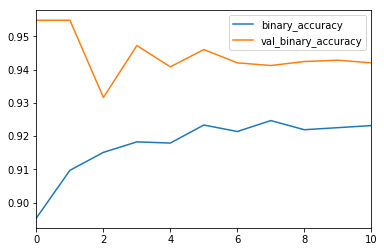

In [110]:
_ = (history_df.loc[:, ["binary_accuracy", "val_binary_accuracy"]]
               .plot())

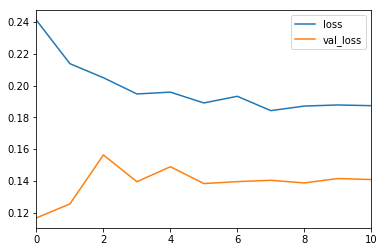

In [109]:
_ = (history_df.loc[:, ["loss", "val_loss"]]
               .plot())

## 6.1 Fine-tuning a model by retraining last few layers

In [165]:
feature_extractor = (keras.applications
                          .MobileNetV2(input_shape=INPUT_SHAPE, include_top=False, weights="imagenet"))

start_fine_tuning_at = 100
for layer in feature_extractor.layers[:start_fine_tuning_at]:
    layer.trainable = False

model_fn = keras.models.Sequential([
    feature_extractor,
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(1, activation="sigmoid")
])

optimzer = keras.optimizers.RMSprop(lr=1e-3)

loss_fn = keras.losses.BinaryCrossentropy()

_metrics = [
    keras.metrics.BinaryAccuracy(),
    keras.metrics.Recall()
]

model_fn.compile(optimzer, loss_fn, metrics=_metrics)

In [ ]:
_training_generator_kwargs = {"rotation_range": 40,
                              "rescale": 1 / 255,
                              "shear_range": 0.2,
                              "zoom_range": 0.2,
                              "horizontal_flip": True,
                              "width_shift_range": 0.2,
                              "height_shift_range": 0.2,
                              "fill_mode": "nearest"}

_training_flow_kwargs = {"dataframe": training_df,
                         "directory": "../data/raw/dogs-vs-cats-redux-kernel-edition/train/",
                         "target_size": TARGET_SIZE,
                         "class_mode": "binary",
                         "batch_size": BATCH_SIZE,
                         "seed": 42}

training_data_flow = (keras.preprocessing
                           .image
                           .ImageDataGenerator(**_training_generator_kwargs)
                           .flow_from_dataframe(**_training_flow_kwargs))
                    
_validation_generator_kwargs = {"rescale": 1 / 255}

_validation_flow_kwargs = {"dataframe": validation_df,
                           "directory": "../data/raw/dogs-vs-cats-redux-kernel-edition/train/",
                           "target_size": TARGET_SIZE,
                           "class_mode": "binary",
                           "batch_size": BATCH_SIZE,
                           "seed": 24}

validation_data_flow = (keras.preprocessing
                             .image
                             .ImageDataGenerator(**_validation_generator_kwargs)
                             .flow_from_dataframe(**_validation_flow_kwargs))

In [166]:
_callbacks = [
    keras.callbacks.ReduceLROnPlateau(monitor='val_binary_accuracy', patience=2, verbose=1, factor=0.5, min_lr=0.00001),
    keras.callbacks.EarlyStopping(patience=10)
]

training_metrics = model_fn.fit_generator(training_data_flow,
                                          epochs=100,
                                          steps_per_epoch=NUMBER_TRAINING_SAMPLES // BATCH_SIZE,
                                          callbacks=_callbacks,
                                          validation_data=validation_data_flow,
                                          validation_steps=NUMBER_VALIDATION_SAMPLES // BATCH_SIZE,
                                          verbose=1)

Epoch 1/100
1250/1250 [==============================] - 299s 239ms/step - loss: 0.2060 - binary_accuracy: 0.9206 - recall_16: 0.9175 - val_loss: 0.9640 - val_binary_accuracy: 0.6652 - val_recall_16: 0.8045
Epoch 2/100
1250/1250 [==============================] - 300s 240ms/step - loss: 0.1340 - binary_accuracy: 0.9498 - recall_16: 0.9507 - val_loss: 0.6090 - val_binary_accuracy: 0.8940 - val_recall_16: 0.9126
Epoch 3/100
1250/1250 [==============================] - 295s 236ms/step - loss: 0.1098 - binary_accuracy: 0.9595 - recall_16: 0.9602 - val_loss: 1.0530 - val_binary_accuracy: 0.8392 - val_recall_16: 0.6830
Epoch 4/100
1250/1250 [==============================] - 298s 238ms/step - loss: 0.1016 - binary_accuracy: 0.9632 - recall_16: 0.9638 - val_loss: 0.3387 - val_binary_accuracy: 0.9596 - val_recall_16: 0.9251
Epoch 5/100
1250/1250 [==============================] - 310s 248ms/step - loss: 0.0916 - binary_accuracy: 0.9678 - recall_16: 0.9677 - val_loss: 1.1184 - val_binary_accura

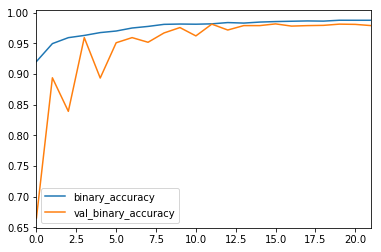

In [169]:
history_df = (pd.DataFrame
                .from_dict(training_metrics.history))

_ = (history_df.loc[:, ["binary_accuracy", "val_binary_accuracy"]]
               .plot())

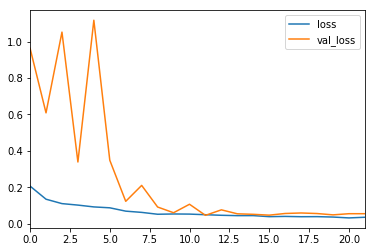

In [170]:
_ = (history_df.loc[:, ["loss", "val_loss"]]
               .plot())

## 7. Retrain the model using all available training data

In [174]:
# define the model
TARGET_SIZE = (160, 160)
INPUT_SHAPE = TARGET_SIZE + (3,)
BATCH_SIZE = 20

feature_extractor = (keras.applications
                          .MobileNetV2(input_shape=INPUT_SHAPE, include_top=False, weights="imagenet"))

start_fine_tuning_at = 100
for layer in feature_extractor.layers[:start_fine_tuning_at]:
    layer.trainable = False

model_fn = keras.models.Sequential([
    feature_extractor,
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(1, activation="sigmoid")
])

optimzer = keras.optimizers.RMSprop(lr=1e-3)

loss_fn = keras.losses.BinaryCrossentropy()

_metrics = [
    keras.metrics.BinaryAccuracy(),
]

model_fn.compile(optimzer, loss_fn, metrics=_metrics)

# define the data flow for training images
_training_generator_kwargs = {"rotation_range": 40,
                              "rescale": 1 / 255,
                              "shear_range": 0.2,
                              "zoom_range": 0.2,
                              "horizontal_flip": True,
                              "width_shift_range": 0.2,
                              "height_shift_range": 0.2,
                              "fill_mode": "nearest"}

_training_flow_kwargs = {"dataframe": df,
                         "directory": "../data/raw/dogs-vs-cats-redux-kernel-edition/train/",
                         "target_size": TARGET_SIZE,
                         "class_mode": "binary",
                         "batch_size": BATCH_SIZE,
                         "seed": 42}

training_data_flow = (keras.preprocessing
                           .image
                           .ImageDataGenerator(**_training_generator_kwargs)
                           .flow_from_dataframe(**_training_flow_kwargs))


# define the training loop
_callbacks = [
    keras.callbacks.ReduceLROnPlateau(monitor='binary_accuracy', patience=2, verbose=1, factor=0.5, min_lr=0.00001),
    keras.callbacks.EarlyStopping(monitor="loss", patience=10)
]

training_metrics = model_fn.fit_generator(training_data_flow,
                                          epochs=100,
                                          steps_per_epoch=25000 // BATCH_SIZE,
                                          callbacks=_callbacks,
                                          verbose=1)

Found 25000 images belonging to 2 classes.
Epoch 1/100
1250/1250 [==============================] - 314s 251ms/step - loss: 0.2040 - binary_accuracy: 0.9243
Epoch 2/100
1250/1250 [==============================] - 297s 237ms/step - loss: 0.1345 - binary_accuracy: 0.9500
Epoch 3/100
1250/1250 [==============================] - 302s 242ms/step - loss: 0.1104 - binary_accuracy: 0.9603
Epoch 4/100
1250/1250 [==============================] - 299s 239ms/step - loss: 0.1019 - binary_accuracy: 0.9629
Epoch 5/100
1250/1250 [==============================] - 304s 243ms/step - loss: 0.0902 - binary_accuracy: 0.9668
Epoch 6/100
1250/1250 [==============================] - 299s 239ms/step - loss: 0.0874 - binary_accuracy: 0.9693
Epoch 7/100
1250/1250 [==============================] - 297s 238ms/step - loss: 0.0813 - binary_accuracy: 0.9710
Epoch 8/100
1250/1250 [==============================] - 289s 231ms/step - loss: 0.0794 - binary_accuracy: 0.9717
Epoch 9/100
1250/1250 [======================

## 8. Submit predictions to Kaggle!

In [175]:
filepaths = glob.glob("../data/raw/dogs-vs-cats-redux-kernel-edition/test/*.jpg")
data = {"filename": []}
for filepath in filepaths:
    filename = filepath.split('/')[-1]
    data["filename"].append(filename)

testing_df = (pd.DataFrame
                .from_dict(data)
                .reset_index(drop=True))

NUMBER_TESTING_SAMPLES, _ = testing_df.shape

### 8.1 Create the testing image generator

In [176]:
_testing_generator_kwargs = {"rescale": 1 / 255}

_testing_flow_kwargs = {"dataframe": testing_df,
                        "directory": "../data/raw/dogs-vs-cats-redux-kernel-edition/test/",
                        "target_size": TARGET_SIZE,
                        "y_col": None,
                        "class_mode": None,
                        "batch_size": BATCH_SIZE,
                        "shuffle": False}

testing_data_flow = (keras.preprocessing
                          .image
                          .ImageDataGenerator(**_testing_generator_kwargs)
                          .flow_from_dataframe(**_testing_flow_kwargs))

Found 12500 images.


### 8.2 Make predictions

In [177]:
if NUMBER_TESTING_SAMPLES % BATCH_SIZE == 0:
    NUMBER_PREDICTION_STEPS = (NUMBER_TESTING_SAMPLES // BATCH_SIZE)
else:
    NUMBER_PREDICTION_STEPS = (NUMBER_TESTING_SAMPLES // BATCH_SIZE) + 1

predictions = model_fn.predict_generator(testing_data_flow,
                                         steps=NUMBER_PREDICTION_STEPS,
                                         verbose=1)

625/625 [==============================] - 110s 175ms/step


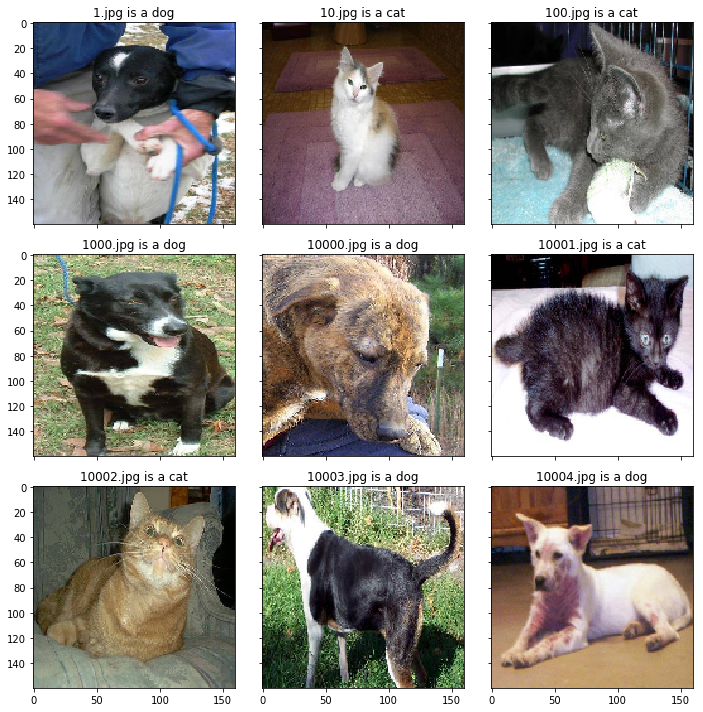

In [178]:
fig, axes = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(10, 10))

idx = 0
for i in range(3):
    for j in range(3):
        filename = testing_df.loc[idx, "filename"]
        probability = predictions[idx, 0]
        category = "dog" if probability >= 0.5 else "cat"
        _filepath = f"../data/raw/dogs-vs-cats-redux-kernel-edition/test/{filename}"
        img = (keras.preprocessing
                    .image
                    .load_img(_filepath, target_size=TARGET_SIZE))
        axes[i, j].imshow(img)
        axes[i, j].set_title(f"{filename} is a {category}")
        idx += 1

fig.tight_layout()

### 8.3 Create the submission file

In [179]:
import os
import time

if not os.path.isdir("../data/kaggle-submissions/dogs-vs-cats-redux-kernel-edition/"):
    os.makedirs("../data/kaggle-submissions/dogs-vs-cats-redux-kernel-edition/")

timestamp = time.strftime("%Y%m%d-%H%M%S")
(pd.DataFrame({"id": range(1, NUMBER_TESTING_SAMPLES + 1), "label": predictions.ravel()})
   .to_csv(f"../data/kaggle-submissions/dogs-vs-cats-redux-kernel-edition/submission-{timestamp}.csv", index=False))

In [180]:
!head $(ls ../data/kaggle-submissions/dogs-vs-cats-redux-kernel-edition/submission-*.csv | tail -n 1)

id,label
1,1.0
2,0.0
3,8.940697e-06
4,1.0
5,0.99999845
6,0.0
7,0.0
8,1.0
9,0.9993955


In [181]:
!tail $(ls ../data/kaggle-submissions/dogs-vs-cats-redux-kernel-edition/submission-*.csv | tail -n 1)

12491,0.031517327
12492,1.0
12493,0.9925995
12494,0.0
12495,0.0
12496,2.6375055e-05
12497,0.99917483
12498,1.0
12499,0.0
12500,1.7881393e-07


In [182]:
%%bash
export KAGGLE_USERNAME="YOUR_USERNAME"
export KAGGLE_KEY="YOUR_API_KEY"
kaggle competitions submit dogs-vs-cats-redux-kernels-edition \
  -f $(ls ../data/kaggle-submissions/dogs-vs-cats-redux-kernel-edition/submission-*.csv | tail -n 1) \
  -m "Fine-tuned transfer learning using MobileNetV2 with imagenet weights."

Successfully submitted to Dogs vs. Cats Redux: Kernels Edition

100%|██████████| 139k/139k [00:06<00:00, 21.6kB/s]
